In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from coolpuppy.lib import io

In [2]:
os.chdir("/exports/igmm/eddie/wendy-lab/elias/Friman2022/contact_screen")

In [3]:
pup_data = io.load_pileup_df("/exports/igmm/eddie/wendy-lab/elias/Friman2022/pileups/Hsieh_mESCs_microC.mm10.mapq_30.1000_mm10-cCREs_ESC_DNase_merged5kb_mm10.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy")

In [4]:
pup_data = pup_data[pup_data["separation"] != "all"]

In [5]:
#Load data
contact_freq = pd.DataFrame({"chrom": [item[0] for sublist in pup_data["coordinates"] for item in sublist],
                             "start1": [int(item[1]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end1": [int(item[2]) for sublist in pup_data["coordinates"] for item in sublist],
                             "start2": [int(item[4]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end2": [int(item[5]) for sublist in pup_data["coordinates"] for item in sublist],
                             "distance_band": ''.join([str(item)*pup_data.loc[pup_data["distance_band"] == item, "vertical_stripe"].reset_index(drop=True)[0].shape[0] for item in pup_data["distance_band"]]).split(")("),                    
                             "contact": [item[0] for sublist in pup_data["vertical_stripe"] for item in sublist]})

In [6]:
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace('(','', regex=False)
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace(')','', regex=False)
contact_freq["coord1"] = contact_freq["chrom"] + "_" + contact_freq["start1"].astype(str) + "_" + contact_freq["end1"].astype(str)
contact_freq["coord2"] = contact_freq["chrom"] + "_" + contact_freq["start2"].astype(str) + "_" + contact_freq["end2"].astype(str)
contact_freq = contact_freq.dropna()

In [7]:
#Load database peaks
cistrome_remap = pd.read_csv("/exports/igmm/eddie/wendy-lab/elias/Friman2022/Peaks/mm10/cistrome_remap_filtered.bed", sep="\t", 
                             dtype={"chrom_cres": str, "start_cres": int, 
                                    "end_cres": int, "ID": str})

In [8]:
#Extract interaction pairs bound or not by RING1B
contact_df = contact_freq.loc[contact_freq["distance_band"] == "100000, 1000000"]
regions = set(cistrome_remap.loc[cistrome_remap["ID_Factor"] == "GSE41314_RNF2", "coords_cre"])
coord1 = set(contact_df["coord1"].unique())
coord2 = set(contact_df["coord2"].unique())
left = coord1.intersection(regions)
right = coord2.intersection(regions)
contact_df["RING1B_bound"] = "None"
contact_df.loc[(contact_df["coord1"].isin(left)) | (contact_df["coord2"].isin(right)),"RING1B_bound"] = "One"
contact_df.loc[(contact_df["coord1"].isin(left)) & (contact_df["coord2"].isin(right)),"RING1B_bound"] = "Both"

/tmp/ipykernel_30066/1743085221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_df["RING1B_bound"] = "None"
/exports/igmm/eddie/chr11/elias/anaconda/envs/coolpuppy_trans/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
contact_df["log2_contact"] = np.log2(contact_df["contact"]+1)

/tmp/ipykernel_30066/1792324766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_df["log2_contact"] = np.log2(contact_df["contact"]+1)


In [10]:
def patch_violinplot():
     from matplotlib.collections import PolyCollection
     ax = plt.gca()
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              art.set_edgecolor((0, 0, 0))

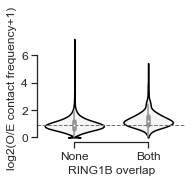

In [11]:
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":16, 
                                "axes.labelsize": 12, "xtick.labelsize": 12,
                                "ytick.labelsize": 12})   
data = contact_df[contact_df["RING1B_bound"] != "One"].reset_index(drop=True)
g = sns.catplot(data = data, 
                x = "RING1B_bound", y = "log2_contact", kind = "violin", 
                height = 2, aspect = 1.25, color="whitesmoke",
                order=["None", "Both"], cut=0)
g.map(plt.axhline, y=data.loc[data["RING1B_bound"] == "None","log2_contact"].median(), 
      ls='--', color='r', linewidth=1)
g.set(xlabel="RING1B overlap", title="", ylabel="log2(O/E contact frequency+1)")
plt.tight_layout()
patch_violinplot()
sns.despine(trim=True)
plt.savefig("./plots/RING1B_overlap.svg")